In [1]:
import Pkg
Pkg.add("FFTW")
using Random, Distributions, StatsPlots, FFTW, StatsBase

In [2]:
## Follows Dr. Zitkovic's example of struct
mutable struct Parameters
    H::Float64
    ndiv::Int64
    dt::Float64
    nsim::Int64
    rate::Int64
    function Parameters( 
            H, ndiv,
            nsim, rate)
        dt = 1.0/rate
        new(H,ndiv,dt,nsim,rate)
    end
end

function Base.show(io::IO, p::Parameters)
    print(
    "Hurst parameter = ", p.H, ", ",
    "ndiv = ", p.ndiv, ", nsim = ", p.nsim
)
end

In [3]:
## Main functions and simulation of BM via Random Walk
function randSum(n::Int64)
    walks = zeros(n)
    for i in 1:n
        U = rand(Uniform())
        if U<.5
            walks[i] = 1
        else
            walks[i] = -1
        end
    end
    return pushfirst!(accumulate(+,walks),0)
end

function BM(p::Parameters)
     Sum = randSum(p.rate)
     return 1/sqrt(p.rate).*Sum
end

function simIntegral(p::Parameters)
    integral = zeros(p.rate+1)
    diffVec  = Array{Float64}(undef, p.rate)
    
    diffVec     = diff(BM(p))
    
    @time for k in 2:p.rate+1
        for m in 1:k-1
            integral[k] += ((k-m)/p.rate)^(p.H-.5)*diffVec[m]
        end
    end
    
    return (diffVec, integral)
end

simIntegral (generic function with 1 method)

In [4]:
## Main functions and simulation of fBM
function cov(p::Parameters, k::Float64)
        return 0.5*(abs(k-1)^(2*p.H)-2*abs(k)^(2*p.H)+abs(k+1)^(2*p.H))
end

function progress_bar(i::Int64, nsim::Int64)
    if (i==1 && nsim >= 50)
        println()
    end
    print("."); flush(stdout)
    if (i % 50 == 0)
        println(i, "/", nsim); flush(stdout)
    end
end

function simulate(p::Parameters; verb = false, prog = false)
    v  = ceil(log2(p.ndiv))
    m  = Int(2*2^v)

    c    = Array{Float64}(undef, m)
    C    = Array{Float64}(undef, m, m)
    Q    = Array{ComplexF64}(undef, m, m)
    ld   = Array{Float64}(undef, m)
    W    = Array{ComplexF64}(undef, m, p.nsim)
    w    = Array{ComplexF64}(undef, m, p.nsim)
    X    = Array{Float64}(undef, p.ndiv, p.nsim)
    fBM  = Array{Float64}(undef, p.ndiv, p.nsim)
    
    for i in 1:m
        if i <= Int(m/2+1)
            c[i] = cov(p,Float64(i-1))
        else i > Int(m/2+1)
            c[i] = cov(p,Float64(m-i+1))
        end
    end
    for j in 1:m
        C[j,:] = circshift(c,j-1)
        for k in 1:m
            Q[j,k] = m^(-.5)*exp(-2*pi*im*(j-1)*(k-1)/m)
        end
    end
    
    ld = real(fft(c))
    
    @time for q in 1:p.nsim
        
        prog && progress_bar(m,p.nsim)
        
        U = rand(Normal())
        V = rand(Normal())
        W[1,q] = U
        W[Int(m/2+1),q] = V
        for l in 2:Int(m/2)
            U = rand(Normal())
            V = rand(Normal())
            W[l,q] = 1/sqrt(2)*(U+im*V)
            W[m-l+2,q] = 1/sqrt(2)*(U-im*V)
        end
        w[:,q] = 1/sqrt(m).*sqrt.(ld).*W[:,q]
        X[:,q] = view(real(fft(w[:,q])),1:p.ndiv)
        fBM[:,q] = cumsum(X[:,q])
    end
    
    return X, fBM
end

simulate (generic function with 1 method)

Parameters:
  Hurst parameter = 0.25, ndiv = 256, nsim = 1
Simulating:   0.000064 seconds (39 allocations: 43.297 KiB)


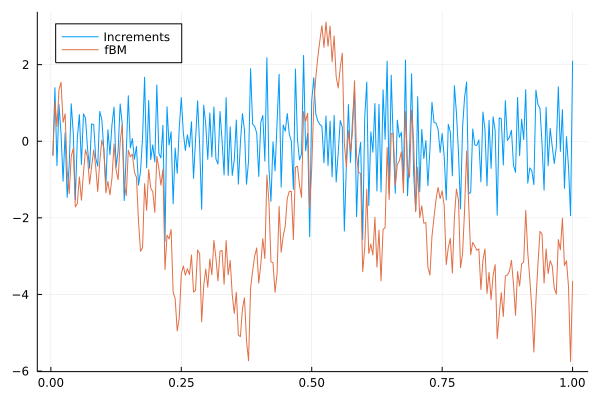

In [5]:
## Test plot of fBM with increments
p = Parameters(
    .25,
    2^8,
    1,
    1)

println("Parameters:\n  ",p)
print("Simulating: ")
X, fBM = simulate(p; verb = true, prog = false)

ts = (1:p.ndiv)/p.ndiv

pfBM = plot(ts, [X[:,1] fBM[:,1]], 
       label=["Increments" "fBM"],legend=:topleft)
plot(pfBM)

In [91]:
X

512×1 Matrix{Float64}:
 -0.16723627948522535
 -1.3468094276525453
  0.16248407811492133
 -0.821949606723335
  0.6542855813377877
 -1.3494640265491373
 -0.0062570984388855555
  1.2789867523143594
 -0.08866533230586293
 -0.5131488142246696
  0.38888679887998207
 -0.7605549167823112
 -1.3556401762286985
  ⋮
  2.570025879856648
 -1.0207037006260462
 -1.339787468201743
 -1.4597923262230397
  2.827345153492348
  1.1759438690177915
 -3.0733461275702436
 -0.39365741897265966
  0.8138330261490352
 -1.5192879208027885
  0.4183594518301931
  0.19042558263826884

Parameters:
  Hurst parameter = 0.7, ndiv = 2048, nsim = 1
Simulating: .  0.000671 seconds (276 allocations: 341.625 KiB)


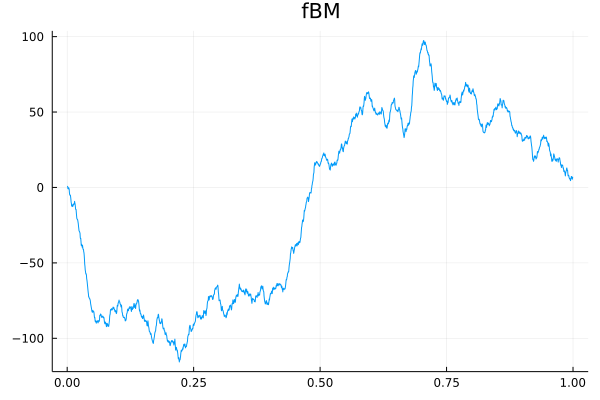

In [107]:
## Test of multiple paths
p = Parameters(
    .7,
    2^11,
    1,
    1)

println("Parameters:\n  ",p)
print("Simulating: ")
X, fBM = simulate(p; verb = false, prog = true);

ts = (1:p.ndiv)/p.ndiv

pfBM = plot( ts, fBM, title = "fBM", label= false)

plot(pfBM)

In [77]:
## Test if BM function works
p = Parameters(
    .3,
    2^9,
    1,
    50000)

m=10000
data1=zeros(m)
data2=zeros(m)
@time for i in 1:m
        data1[i] = BM(p)[p.rate+1]
        data2[i] = (BM(p)[p.rate+1])^2
      end
return (mean(data1),mean(data2))

 20.377727 seconds (238.98 k allocations: 29.810 GiB, 9.04% gc time)


(-0.010132965646838047, 0.9870990560000003)

  0.382264 seconds


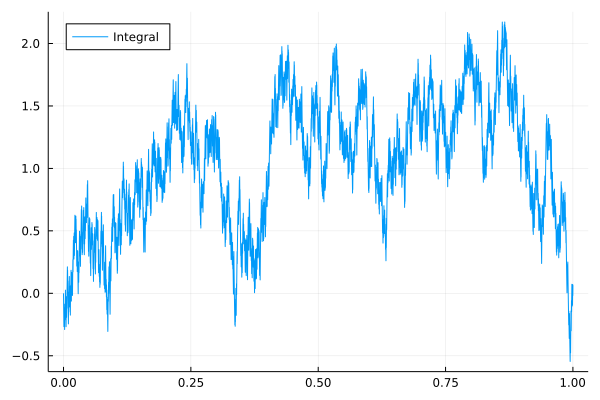

In [66]:
## Test plot of BM with increments
p = Parameters(
    .3,
    2^9,
    1,
    5000)

dif, tBM = simIntegral(p)

tt = collect(0:p.dt:1)

pInt = plot(tt, tBM,
       label="Integral",legend=:topleft)
plot(pInt)

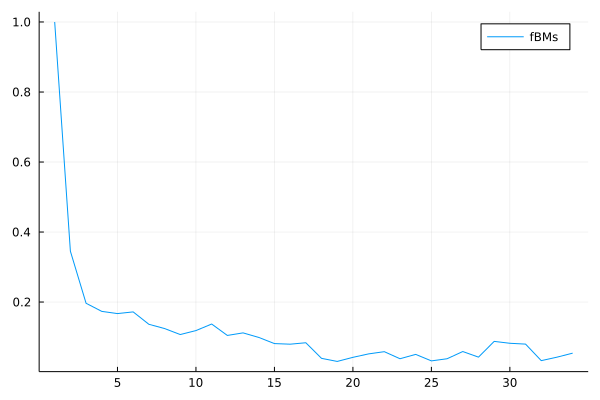

In [108]:
## Plotting autocovariance function on increments
plot(autocor(X[:,1]), label = "fBMs")
#plot!(autocor(diff(tBM)), label="Integral")